# PharmSci 175/275 (UCI)
## What is this?? 
The material below is Lecture 3 (on working with molecules, generating 3D structures, and shape methods) from Drug Discovery Computing Techniques, PharmSci 175/275 at UC Irvine. 
Extensive materials for this course, as well as extensive background and related materials, are available on the course GitHub repository: [github.com/mobleylab/drug-computing](https://github.com/mobleylab/drug-computing)

This material is a set of slides intended for presentation with RISE as detailed [in the course materials on GitHub](https://github.com/MobleyLab/drug-computing/tree/master/uci-pharmsci/lectures/energy_minimization). While it may be useful without RISE, it will also likely appear somewhat less verbose than it would if it were intended for use in written form.

# Molecules, 3D structure, and shape

Today: Chemistry tools in Python; working with molecules; generating 3D conformers; shape search methods

### Instructor: David L. Mobley

### Contributors to today's materials:
- David L. Mobley
- AK Nandkeolyar
- Danielle Bergazin

This notebook requires the OpenEye toolkits on top of a standard scientific Python installation.

## Preparation for using Google Colab (SKIP IF RUNNING LOCALLY))

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/3D_structure_shape/3D_Structure_Shape.ipynb)

If you are running this on Google Colab, you need to take a couple additional steps of preparation:
1) Mount your Google Drive to this notebook:

In [2]:
# Run cell if using collab

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

ModuleNotFoundError: No module named 'google'

2) **If you are running this on Google Colab, pip install dependencies**:

In [ ]:
!pip install -i https://pypi.anaconda.org/openeye/simple openeye-toolkits

3) **Make sure your OpenEye license is on your Drive and configured**; adjust the path below if needed and then run this cell to test:

In [ ]:
license_filename = '/content/drive/MyDrive/oe_license.txt'
import openeye

import os
if os.path.isfile(license_filename):
  license_file = open(license_filename, 'r')
  openeye.OEAddLicenseData(license_file.read())
  license_file.close()
else:
  print("Error: Your OpenEye license is not readable; please check your filename and that you have mounted your Google Drive")

licensed = openeye.oechem.OEChemIsLicensed()
print("Was your OpenEye license correctly installed (True/False)? " + str(licensed))
if not licensed:
  print("Error: Your OpenEye license is not correctly installed.")
  raise Exception("Error: Your OpenEye license is not correctly installed.")

4) If you would like the files used in this notebook to work properly, place the course GitHub repo into your Google Drive and then edit the path below so it points to the location of this lecture's folder, then evaluate this cell:

In [ ]:
# Run cell if using collab

# Move into directory so that files for this lecture can be accessed
%cd /content/drive/MyDrive/drug-computing/uci-pharmsci/lectures/3D_structure_shape/
%ls 

# Working with molecules in Python: OpenEye toolkits, 3D structures, and shape overlays

- We often want to work with molecules or sets of molecules
- Perhaps from name or [SMILES string](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
- Maybe as a 2D drawing from ChemDraw, MarvinSketch, or ChemDoodle
- Maybe from crystal structure with protein (but need to fill in missing chemistry, protons)

## Today: Loading and working with molecules, generating conformers, shape overlays

Serves to introduce the [OpenEye toolkits](www.eyesopen.com) via:
1. Loading molecules from files/names/SMILES
2. Generating 3D conformations
3. Doing shape overlays 
4. Writing out the final molecules

The [OpenEye Python toolkit documentation](http://docs.eyesopen.com/toolkits/python/) is online, and they also have a [cookbook](https://docs.eyesopen.com/toolkits/cookbook/python/) with a variety of interesting examples.

## Here we will draw mainly on five OpenEye toolkits
* `OEChem`: The generic OpenEye chemistry toolkit, for working with molecules (reading/writing, traversing atoms/bonds, etc)
* `OEOmega`: Omega is OpenEye's toolkit for working with molecular conformations/generating 3D conformations
* `OEShape`: Their shape toolkit, for doing things like shape overlays of molecules
* `OEIUPAC`: For working with chemical naming
* `OEDepict`: For depiction of small molecules

We need to start off by importing these so we can work with them here (REMINDER: be sure to shift-enter/hit play in the box below to evaluate it so that you import these for yourself):

In [12]:
from openeye.oechem import *
from openeye.oeiupac import *
from openeye.oeomega import *
from openeye.oeshape import *
from openeye.oedepict import *

# Now we need to see how to load molecules
- We'll start by loading molecules we draw
- Then we'll load from other formats
- Often a name or SMILES string is a better starting point than a 2D drawing
- But 2D drawings are commonly provided by experimental collaborators

## Most 2D viewers can save or export useful molecules; MarvinSketch is a good free option

* There's an [online (web-based) version](https://marvinjs-demo.chemaxon.com/latest/) requiring javascript
* As well as a [free downloadable version](https://www.chemaxon.com/products/marvin/marvinsketch/)

With Marvin you should be able to easily make some molecules and download them in various formats for manipulating here. Draw a molecule you'd like to work on, then you can access it in several formats:
* For SMILES: Select the molecule, choose "Edit">"Copy as Smiles"
* For compound name: Choose "Structure">"Structure to name">"Generate name"
* For a file: Select the molecule, choose "File">"Save as..." and select your file format. MDL .mol files are fairly universal.

## Let's take an example

We'll load all three formats using the OpenEye toolkits. As a starting point let's take this molecule drawn in Marvin:


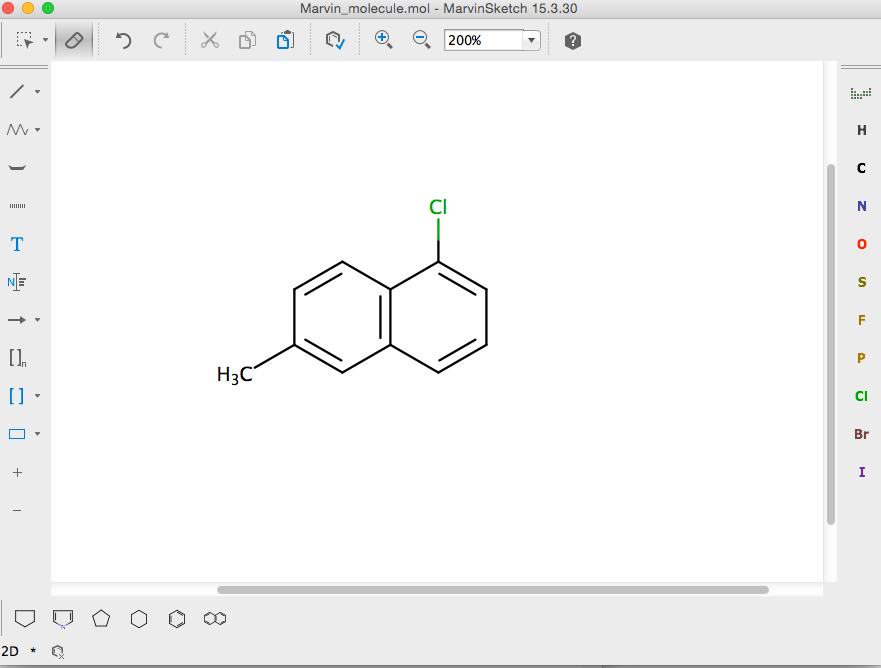

In [3]:
from IPython.display import Image
Image('Marvin_molecule.png',width = 600) #, height = 300)

We obtain the SMILES and compound name ("CC1=CC2=C(C=C1)C(Cl)=CC=C2" and "1-chloro-6-methylnapthalene", respectively) and I exported the molecule to "Marvin_molecule.mol".

## Next we load the molecule 

Now we move to Python to load the molecule, starting with SMILES

In [4]:
#First, we create an empty OEChem molecule object which we will store our molecule into
mol_from_smiles = OEMol()

#Next we grab our SMILES string from Marvin
smiles = "CC1=CC2=C(C=C1)C(Cl)=CC=C2"

#Then we parse the SMILES string
OEParseSmiles(mol_from_smiles, smiles)

#If successful, we should see no error message and the function will output 'True'. 
#We could catch this in a variable if we wanted.

True

## Let's check we have the right molecule by depicting it

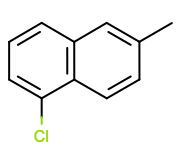

In [5]:
import openeye.oedepict as oedepict # Use OpenEye depiction toolkit
oedepict.OEPrepareDepiction(mol_from_smiles)
oedepict.OERenderMolecule("DepictMolSimple.png", mol_from_smiles)
Image('DepictMolSimple.png',width = 200)

Yup, that's it, just rotated a bit.

## Next, let's work from the IUPAC name

In [6]:
#Create a new OEMol
mol_from_name = OEMol()

#Store our name
name = "1-chloro-6-methylnapthalene"

#Parse the name
OEParseIUPACName(mol_from_name, name)

#Again, if successful, we should see no error message and the function will output 'True'.

True

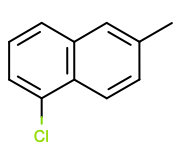

In [7]:
oedepict.OEPrepareDepiction(mol_from_name)
oedepict.OERenderMolecule("DepictMolName.png", mol_from_name)
Image('DepictMolName.png',width = 200)

## Let's read it from a file

In [8]:
#First, we need to initialize an OpenEye "molecule stream" to read from a file - in this case an input stream
istream = oemolistream( 'Marvin_molecule.mol') #oemolistream is an openeye molecule input stream. We name it istream

#Next we create a molecule object
mol_from_file = OEMol()

#We read the molecule
OEReadMolecule( istream, mol_from_file)

#Close our file
istream.close()

#Here there should be no message if successful.

## We can also save images to files easily enough

In [9]:
# Set width, height, and whether or not to display hydrogens
width=500
height=200
supH = True #Suppress hydrogens?

# Prepare depiction/options
mol = oechem.OEMol(mol_from_smiles) # Create new OEMol; without this, it might flatten your molecule
dopt = OEPrepareDepictionOptions() # Get options
dopt.SetSuppressHydrogens(supH) # Hide hydrogens
OEPrepareDepiction(mol, dopt) # Prepare depiction
opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale) # Set size options/scaling

# Set up display and export image to file
disp = OE2DMolDisplay(mol, opts)
OERenderMolecule('test_image.pdf', disp, False)

True

You should now have a `test_image.pdf` file in this directory.

In [17]:
!ls -t
# On colab you will need to prefix this with % to indicate it is a shell command

3D_Structure_Shape.ipynb   mymolecule.mol2
test_image.pdf             morphine_tramadol_mine.png
DepictMolName.png          morphine_tramadol.png
DepictMolSimple.png        Marvin_molecule.png
ref.mol2                   Marvin_molecule.mol


## In general, use SMILES or files for storing molecules -- not names

- SMILES and files are most generally useful/robust
- Chemical names quickly become difficult (or impossible) to automatically parse
- SMILES are an excellent flexible general representation for 1D
- If 2D or 3D is needed, use files, e.g. `.mol`, `.sdf`, or `.mol2`

Tangent: Never use compound names as filenames as they can contain special characters

## Let's check some simple info on our molecules

In [10]:
#First, we set up a 'for' loop over the three molecules we generated so we can apply the same commands to each
for mol in [mol_from_smiles, mol_from_name, mol_from_file]:
    #Now let's print some properties of our molecule
    print("Number of atoms: ", mol.NumAtoms())

Number of atoms:  12
Number of atoms:  12
Number of atoms:  12


## Now a quick exercise: Check the atomic number of your atoms

__Use the OpenEye toolkit [documentation on atom properties](http://docs.eyesopen.com/toolkits/python/oechemtk/atomproperties.html), plus the example code snippet below, to update the code above to print out the atomic number of all the atoms__. 

The code snippet is intended to illustrate how you can use a `for` loop to traverse the atoms within a molecule (in this case, with a boring result):

In [11]:
for atom in mol.GetAtoms():
    print(atom.GetFormalCharge())

0
0
0
0
0
0
0
0
0
0
0
0


Remember, if you want to update this to work on a different molecule, you will have to re-run not just this cell but also the cells above which generate the molecule.

# Now we want to work with molecules in 3D
**So far all we had was a 1D or 2D representation**

- Molecules are 3D
- So far all we have is flat, 1D or 2D info
- Modeling (e.g. energies, forces) requires 3D info
- So we need 3D coordinates
- Where do we get them?

## We need a tool to generate starting coordinates; OpenEye's Omega is one option

- Omega is a good starting point
- Uses molecular fragment libraries
- See [Omega theory documentation](http://docs.eyesopen.com/toolkits/python/omegatk/omegatheory.html).

So here, let's go ahead and generate a 3D conformation of our molecule:

In [7]:
#First we set up Omega
#Initialize class
omega = OEOmega() 
#Only generate one conformer for our molecule
omega.SetMaxConfs(1) 
#Set to False to pick random stereoisomer if stereochemistry is not specified (not relevant here)
omega.SetStrictStereo(False) 
#Be a little loose about atom typing to ensure parameters are available to omega for all molecules
omega.SetStrictAtomTypes(False) 

In [8]:
#Let's create a new molecule from our old molecule
mol = OEMol(mol_from_file)

#Now we generate conformations for our molecule from above. 
omega(mol)
print(mol.NumAtoms())

#If this works properly, you should get a number below
#You might notice that it differs from the number you got above. Why?

21


## Let's visualize this molecule - first write it to a file

In [9]:
#First we create an output stream (just like we did for an input stream)
ostream = oemolostream( 'mymolecule.mol2')
#Now we write our molecule
OEWriteMolecule(ostream, mol)
#And close the output stream
ostream.close()

In [10]:
print(ostream)

<openeye.oechem.oemolostream; proxy of <Swig Object of type 'OEChem::oemolostream *' at 0x1180d0930> >


## Let's visualize this molecule

In [11]:
# Visualize using py3dmol
import py3Dmol

viewer = py3Dmol.view(data=open('mymolecule.mol2','r').read(), 
                      style={'stick': {}})
viewer.show()


# Can also try visualizing with nglview; nglview has more features, but is more finicky to get working
#import mdtraj, nglview
#from google.colab import output
#output.enable_custom_widget_manager()
#traj = mdtraj.load('mymolecule.mol2')
#view = nglview.show_mdtraj(traj)
#view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You could also visualize using VMD (a common molecular simulation viewer), PyMol, or Chimera or similar

# Next, we look at shape overlays

### Shape overlays can provide valuable information on the structure of an active site or binding pocket

- Ligands of same receptor often have similar 3D shape, chemistry
- Substantial differences in 2D structure
- So shape comparison provides info on binding site shape/structure (even without receptor)


### Morphine and tramadol provide an example:

In [ ]:
from IPython.display import Image
Image('morphine_tramadol.png', width = 800)


- [Sun et al., Drug Discov Today. 2012 Apr; 17(7-8): 310–324.](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3328312/), - Tramadol overlaid onto morphine
- no obvious chemical similarity but high shape similarity
- early example of "scaffold hopping": Scaffold changed but activity remains

### Here we'll try and reproduce that overlay

In [ ]:
#Let's first generate morphine and tramadol from their names
morphine= OEMol()
OEParseIUPACName(morphine, 'morphine')
#Make sure we get 'True' so we know it worked:

In [ ]:
#What about tramadol?
tramadol = OEMol()
OEParseIUPACName(tramadol, 'tramadol')

In [ ]:
#In older toolkit versions that doesn't work; if not, pull the IUPAC name from Wikipedia.
OEParseIUPACName(tramadol, '2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol')

### Depict them to make sure they processed properly! 

In [ ]:
# your code here

### Let's set up Omega again for conformer generation

In [ ]:
#We make sure Omega is loaded and initialized
#This time we want to consider multiple conformations, since the OpenEye shape toolkit will just do a rigid
#overlay of whatever conformations we give it onto one another. But here, at least one of the molecules
#has substantial flexibility, and we want to find the conformation which results in the best match
omega = OEOmega() #Initialize class
omega.SetMaxConfs(100) #Here we want to use more conformers if needed
omega.SetStrictStereo(False) #Set to false to pick random stereoisomer if stereochemistry is not specified
omega.SetStrictAtomTypes(False) #Be a little loose about atom typing to ensure parameters are available to omega for all molecules
#In this case the 'StrictStereo' parameter above will also matter. Since tramadol has an unspecified stereocenter, 
#this will cause Omega to pick a random stereoisomer. Without specifying this, Omega will refuse to do anything.

In [ ]:
#Now let's generate 3D conformations for morphine and label it our 'reference' molecule:
refmol = morphine
omega(refmol)

#Now we generate 3D conformations for tramadol and label it our 'fitmol', the molecule to be fit onto the reference
fitmol = tramadol
omega(fitmol)
fitmol.SetTitle('tramadol')

#And just so we can see how this works, let's write out morphine to a mol2 file for viewing later
ofs = oemolostream('ref.mol2')
OEWriteMolecule(ofs, refmol)
ofs.close()

### Now we'll do a shape overlay

You'll see some of this again in homework if you do the 3D structure/shape assignment, but you won't need to really change it. Still, I'll briefly explain how it works.

In [ ]:
# Open output stream for output molecule
outfs = oemolostream('fitted_output.mol2')
# How many conformers will we generate for fitting?
nconfs = 20

In [ ]:
# Setup ROCS to provide specified number of conformers per hit
options = OEROCSOptions()
options.SetNumBestHits(1)
options.SetConfsPerHit(nconfs)
rocs = OEROCS(options)
rocs.AddMolecule(fitmol) #Add our molecule as the one we are fitting

In [ ]:
# Loop over results and output
for res in rocs.Overlay(refmol):
    outmol = res.GetOverlayConf() #Use GetOverlayConf to get just the best; GetOverlayConfs for all
    OERemoveColorAtoms(outmol)
    OEAddExplicitHydrogens(outmol)
    OEWriteMolecule(outfs, outmol)
    print("title: %s  tanimoto combo = %.2f" % (outmol.GetTitle(), res.GetTanimotoCombo()))
outfs.close()

### Now let's visualize and see if that worked to reproduce the overlay

In [ ]:
import py3Dmol
#First we assign the py3Dmol.view as viewer
viewer = py3Dmol.view()
viewer.addModel(open('ref.mol2', 'r').read(),'mol2')
viewer.addModel(open('fitted_output.mol2', 'r').read(),'mol2')
viewer.setStyle({'stick':{}})
#Zooming into all visualized structures 
viewer.zoomTo()
#And we finally visualize the structures using the command below
viewer.show()

In [ ]:
# optionally, use nglview
#from google.colab import output
#output.enable_custom_widget_manager()
#import mdtraj, nglview
#ref = mdtraj.load('ref.mol2')
#view = nglview.show_mdtraj(ref)
#fitted = mdtraj.load('fitted_output.mol2')
#view.add_trajectory(fitted)
#the two lines below may not work for you
##view[1].clear_representations() #Use this and the below to switch one to blue sticks to make it easier to see
##view[1].add_ball_and_stick(color='blue')
#view

I've also noted an mdtraj or nglview issue where if the mol2 file is multi-conformer, the view doesn't appear properly (maybe it shows the last match only, or the alignment gets messed up by the multiple conformations)

If you'd like to see ALL the overlaid conformations, use `GetConfs()` rather than `GetConf()` above and visualize in PyMol or VMD or Chimera or another viewer which allows you to loop through conformations.